# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

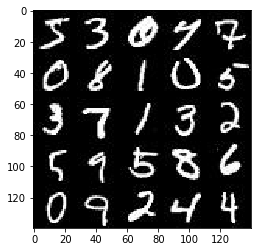

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

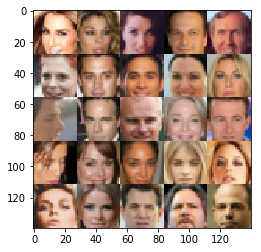

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
   
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)* 
                                                                         (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    # Optimize

    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _ , image_width, image_height, image_channels = data_shape
    image_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(image_input, z_input, len(data_image_mode))
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                steps +=1
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, image_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_input, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.0807... Generator Loss: 0.1216
Epoch 1/2... Discriminator Loss: 2.3677... Generator Loss: 0.2728
Epoch 1/2... Discriminator Loss: 2.0630... Generator Loss: 0.3302
Epoch 1/2... Discriminator Loss: 2.0522... Generator Loss: 0.4202
Epoch 1/2... Discriminator Loss: 1.7188... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 1.8116... Generator Loss: 0.4246
Epoch 1/2... Discriminator Loss: 1.6860... Generator Loss: 0.5846
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 1.4746... Generator Loss: 0.5226


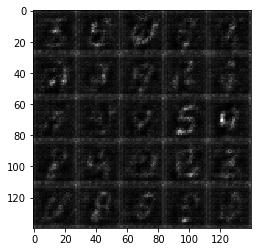

Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 1.4730... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.6104
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.6309
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 1.2025


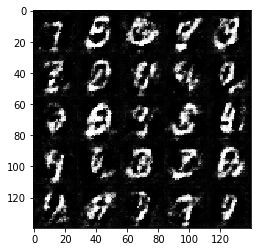

Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.6001
Epoch 1/2... Discriminator Loss: 1.5705... Generator Loss: 0.3984
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 1.4767... Generator Loss: 0.5036
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.9609
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.5402
Epoch 1/2... Discriminator Loss: 1.6074... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 0.6636


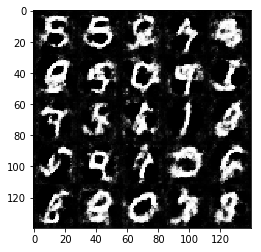

Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.7856
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.7362


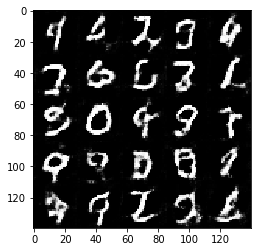

Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.6577
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.9209
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.8335
Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.6478
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.6622
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.9057
Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.6713


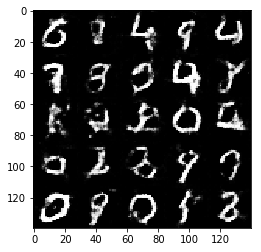

Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.6332
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 1.6480... Generator Loss: 0.4051
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.6129
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.6626


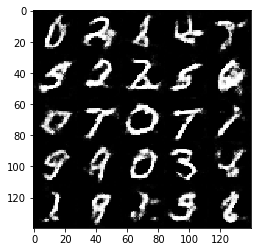

Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.5308
Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.6822
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 0.8465
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.9265


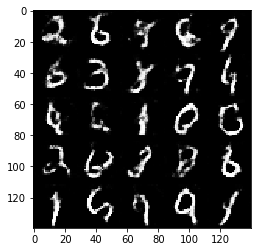

Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.5575
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.6104... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 1.4565... Generator Loss: 0.5899
Epoch 1/2... Discriminator Loss: 1.5362... Generator Loss: 0.5208


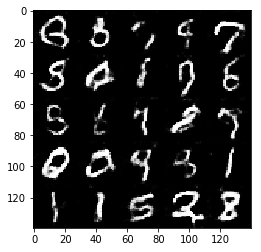

Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 1.0831
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 1.0605
Epoch 1/2... Discriminator Loss: 1.5138... Generator Loss: 0.5149
Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.8340


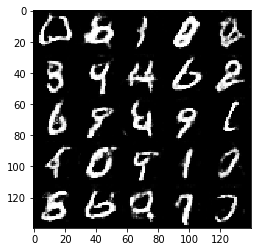

Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.9118
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.7629
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.7257
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.8965
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.6265


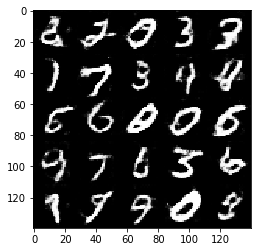

Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 0.7188
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.4942... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.4521... Generator Loss: 0.5353
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.5030... Generator Loss: 0.5170
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.5786
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.6997


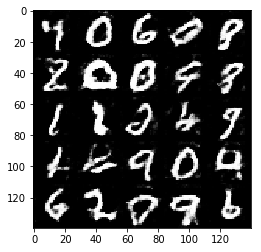

Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.8947
Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.5744
Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 1.5711... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 1.4699... Generator Loss: 0.5702
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.6174
Epoch 2/2... Discriminator Loss: 1.4879... Generator Loss: 0.4984
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 0.6514


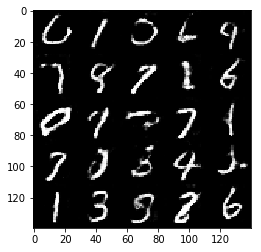

Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.5667
Epoch 2/2... Discriminator Loss: 1.3169... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 1.4871... Generator Loss: 0.4678
Epoch 2/2... Discriminator Loss: 1.3453... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 1.5072... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 1.6429... Generator Loss: 0.3894
Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.8844
Epoch 2/2... Discriminator Loss: 1.4672... Generator Loss: 1.0632


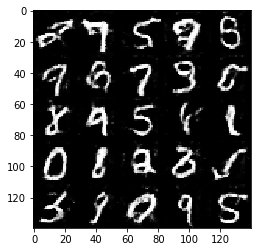

Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.6197
Epoch 2/2... Discriminator Loss: 1.6373... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.4949... Generator Loss: 0.4773
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.5896
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.5776... Generator Loss: 1.2332


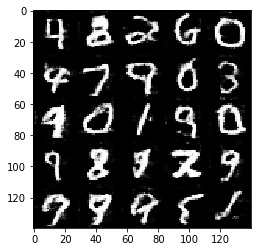

Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 1.6111... Generator Loss: 0.4125
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.5642... Generator Loss: 0.4484
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.8290


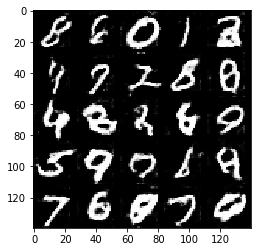

Epoch 2/2... Discriminator Loss: 1.5330... Generator Loss: 0.4713
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 0.5653
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.8539
Epoch 2/2... Discriminator Loss: 1.4663... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.6063


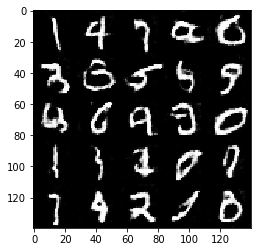

Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.7886
Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 1.5044... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.5926
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 1.4766... Generator Loss: 0.4753
Epoch 2/2... Discriminator Loss: 1.7246... Generator Loss: 0.3223


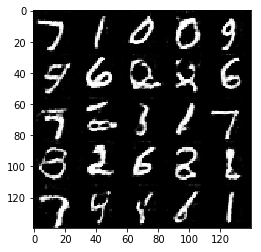

Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 1.4483... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 1.4640... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 1.0101
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.5238
Epoch 2/2... Discriminator Loss: 1.2312... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.7264


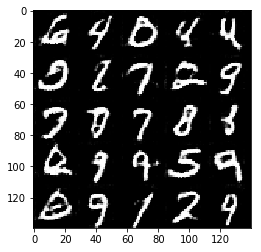

Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.6253
Epoch 2/2... Discriminator Loss: 1.5439... Generator Loss: 0.4803
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.6496
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.5703


In [13]:
batch_size = 64
z_dim = 64
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1395... Generator Loss: 0.0371
Epoch 1/1... Discriminator Loss: 3.3471... Generator Loss: 0.1038
Epoch 1/1... Discriminator Loss: 2.2952... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 2.2099... Generator Loss: 0.3063
Epoch 1/1... Discriminator Loss: 2.2432... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 2.3088... Generator Loss: 0.3376
Epoch 1/1... Discriminator Loss: 1.9601... Generator Loss: 0.4217
Epoch 1/1... Discriminator Loss: 1.9720... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 2.0422... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.9247... Generator Loss: 0.5488


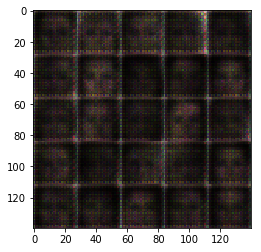

Epoch 1/1... Discriminator Loss: 1.7965... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.6597... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.6623... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.7545... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.5609


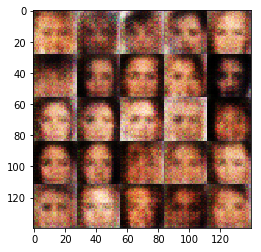

Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.6932


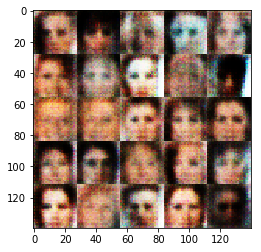

Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.6519


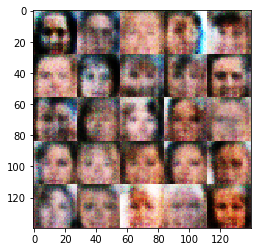

Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.6527


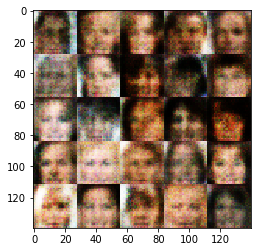

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7298


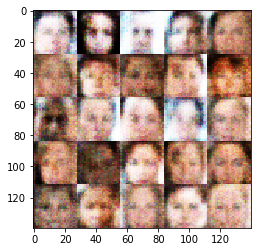

Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7228


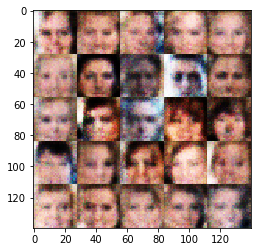

Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7620


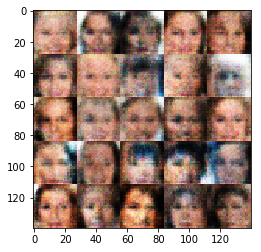

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7749


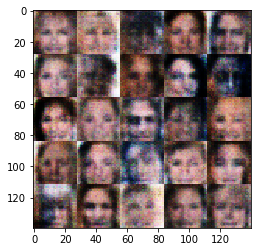

Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7488


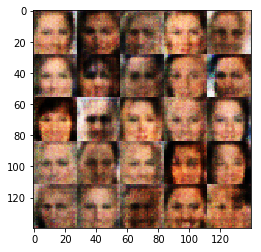

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7205


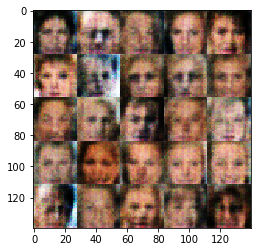

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7739


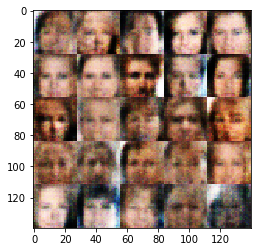

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7787


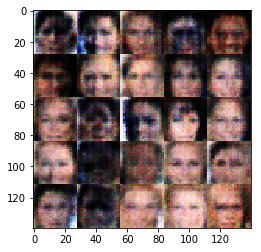

Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7149


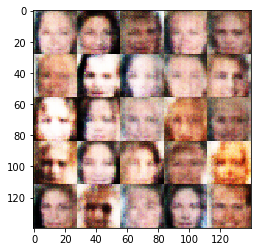

In [14]:
batch_size = 64
z_dim = 64
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.